In [1]:
# Copyright 2019 Google LLC
# Copyright 2025 Anonymized Authors

# Licensed under the Apache License, Version 2.0 (the "License"); 
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at
# https://www.apache.org/licenses/LICENSE-2.0
"""
This notebook evaluates greedy selection in combination with different mutation techniques.

Requirements: 

-This notebook requires that tensorflow and numpy be installed within the 
Python environment you are running this script in. 

"""
import matplotlib.pyplot as plt
import sys; sys.path.append('..')
from utils.nas_utils import load_nasbench, mutate_spec, run_xevolution, greedy_selection, crossover, NASBench, guided_mutation
from utils.plotting import plot_all
from IPython.display import clear_output

nasb = load_nasbench()




No GPU.
Loading dataset from file... This may take a few minutes...
Loaded dataset in 295.3212356567383 seconds


In [ ]:
# here, we test out different mutation methods
# our mutation functions have to follow 
# def mutation(nasbench, population) -> mutated_population 



import copy
import random
from utils.nas_utils import SpecOneHot
import numpy as np 


    

def regular_mutation(nasbench: NASBench, population, mutation_rate=0.5):
    """Mutates each individual of a population."""
    mutated = []
    for p in population:
        new_spec = mutate_spec(p, nasbench, mutation_rate)
        mutated.append(new_spec)
    return mutated



def swap_mutation(nasbench, population):
    """Swaps two operations in each individual of the population."""
    mutated_population = []

    for individual in population:
        new_spec = copy.deepcopy(individual)
        
        # Choose two distinct nodes to swap
        idx1, idx2 = random.sample(range(len(new_spec.ops)), 2)

        # Swap operations
        new_spec.ops[idx1], new_spec.ops[idx2] = new_spec.ops[idx2], new_spec.ops[idx1]

        # Validate and append
        if nasbench.is_valid(new_spec):
            mutated_population.append(new_spec)

    return mutated_population

def guided_mutation(nasb, population):
    psize = len(population)
    
    inputs = [x.to_flat() for x in population]
    mutation_inputs = np.array(inputs)
    summed = np.sum(mutation_inputs, axis=0)

    # Define the probabilities for mutation
    probs_mat_1 = summed[:SpecOneHot.flat_matrix:2] / psize 
    probs_mat_1 /= np.sum(probs_mat_1)  
    probs_mat_0 = 1 - probs_mat_1  
    probs_mat_0 /= np.sum(probs_mat_0)  

    probs_ops_1 = summed[SpecOneHot.flat_matrix:] / psize
    probs_ops_1 /= np.sum(probs_ops_1)  
    probs_ops_0 = 1 - probs_ops_1
    probs_ops_0 /= np.sum(probs_ops_0)  

    children = []
    for i in range(psize):
        while True:
            child_spec = mutation_inputs[i, :].astype(int)

            # Select indices based on the probabilities using np.random.choice (similar to torch.multinomial)
            mat_index_1 = np.random.choice(len(probs_mat_0), 1, p=probs_mat_0)[0]
            mat_index_0 = np.random.choice(len(probs_mat_1), 1, p=probs_mat_1)[0]


            ops_index = np.random.choice(len(probs_ops_1), 1, p=probs_ops_1)[0] + SpecOneHot.flat_matrix

            # Modify the child_spec array based on the selected indices
            base = (ops_index - (ops_index % 3))  # Ensure base is aligned to 3 operations
            remove = [base, base + 1, base + 2]
            child_spec[remove] = 0
            child_spec[ops_index] = 1

            # mutate adjacency matrix
            child_spec[mat_index_1*2] = 1
            child_spec[mat_index_1*2+1] = 0

            child_spec[mat_index_0*2+1] = 1
            child_spec[mat_index_0*2] = 0

            spec = SpecOneHot.spec_from_flat(child_spec)
            
            if nasb.is_valid(spec):
                children.append(spec)
                break

    return children


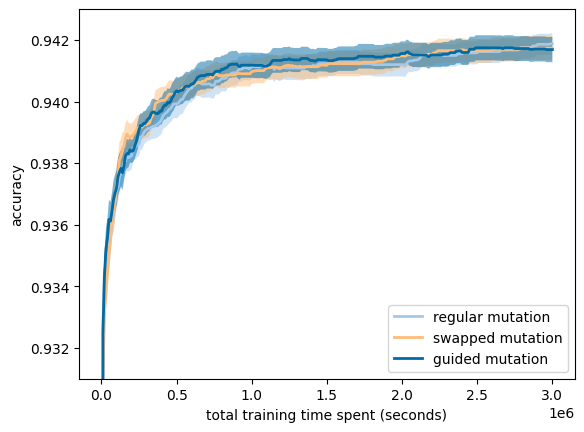

Running repeat 77


In [18]:
# comparing different methods

m1 = lambda nasb, crossed_parents: regular_mutation(nasb, crossed_parents, 0.5)
m2 = lambda nasb, crossed_parents: guided_mutation(nasb, crossed_parents)
m3 = lambda nasb, crossed_parents: guided_mutation(nasb, crossed_parents)


exp1 = {
    "data": 
    {
        "regular mutation" : [[],"Light Blue"],
        "swapped mutation" : [[],"Light Orange"],
        "guided mutation" : [[],"Dark Blue"],
    },
    "config": 
    {
        "budget" : int(3e6),
        "limits" : (0.931, 0.943),
        "n" : 300,
        "print_every" : 2,
        "confidence_intervall" : True,
        "pvalue" : 0.05,
        "significant_areas": False,
        "dataset" : "test",
   }
}

budget = exp1["config"]["budget"]
for run in range(exp1["config"]["n"]):
    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, m1, budget, 50)
    exp1["data"]["regular mutation"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, m2, budget, 50)
    exp1["data"]["guided mutation"][0].append((times, best_valid, best_test))

    nasb.reset_budget_counters()
    times, best_valid, best_test = run_xevolution(nasb, greedy_selection, crossover, m3, budget, 50)
    exp1["data"]["swapped mutation"][0].append((times, best_valid, best_test))

    if (run % exp1["config"]["print_every"] == 0):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        plot_all(exp1, ax)
        plt.show()
        print('Running repeat %d' % (run + 1))

clear_output(wait=True)
fig, ax = plt.subplots()
plot_all(exp1, ax)
plt.show()